In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump

# Setting up nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SURIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SURIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Reading the data
df = pd.read_csv('new_spam_comments_dataset.csv')

# Exploring the data
print(df.head())


         COMMENT_ID              AUTHOR                 DATE  \
0  e7xj2zkrq5e85mwz        James Miller  2013-12-21T02:26:48   
1  io7ngg5o8bq8z648  Alexander Martinez  2013-11-19T05:20:07   
2  5dw3kdx2upj9jtpe       Sophia Garcia  2013-12-05T20:51:36   
3  1be8l3fzfpxl525o        Sophia Jones  2013-11-17T23:06:10   
4  gr1c9nu3o2p3g1jm     James Rodriguez  2013-11-28T19:07:33   

                          YOUTUBE_TITLE  \
0      Travel Guide: Exploring Thailand   
1                The Art of Photography   
2   Ultimate Guide to Digital Marketing   
3  Effective Time Management Strategies   
4       Mastering the Basics of Drawing   

                                             CONTENT  CLASS  
0  Unlock premium content! https://bit.ly/hvu1hj ...      1  
1          Amazing video! Check out my other videos!      0  
2  Be your own boss! https://tinyurl.com/3n5nfh O...      1  
3  I'm impressed! Don't forget to share with your...      0  
4  I learned a lot from this video. Help me re

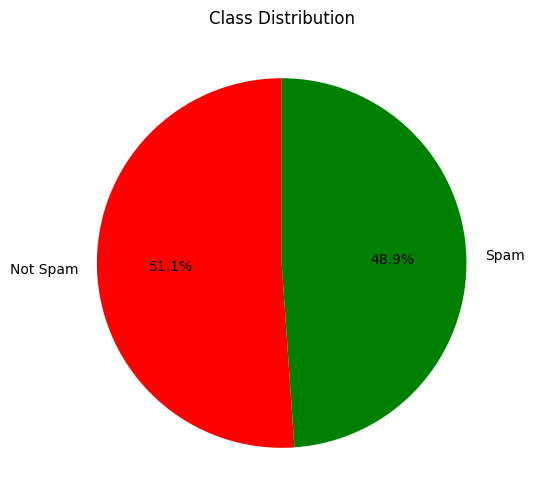

In [3]:
# Adding a class label column
df['class_label'] = df['CLASS'].map({1: 'Spam', 0: 'Not Spam'})

# Visualizing class distribution
class_counts = df['class_label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Class Distribution')
plt.show()


In [4]:
# Preprocessing comments
comments = df['CONTENT'].apply(lambda x: x.lower())
print(comments)
labels = df['CLASS'].values
comments = comments.apply(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'http', str(x)))
comments = comments.apply(lambda x: x.replace('\ufeff', ''))
comments_token = comments.apply(lambda x: x.split())


0      unlock premium content! https://bit.ly/hvu1hj ...
1              amazing video! check out my other videos!
2      be your own boss! https://tinyurl.com/3n5nfh o...
3      i'm impressed! don't forget to share with your...
4      i learned a lot from this video. help me reach...
                             ...                        
995    click here for free stuff! https://bit.ly/65gy...
996         i enjoyed watching this. limited time offer!
997    you're doing a great job! share this with some...
998    you've earned a new subscriber! follow me on s...
999    unlock premium content! spam tag a friend who ...
Name: CONTENT, Length: 1000, dtype: object


### preprocessing the contents
 * comments are converted to lowercase
 * The regular expression is used to remove the URL of a website which is not useful for current text classification.
 * Removed ufe encoding as it is appears randomly

In [5]:
# Removing stopwords
stop_words = set(stopwords.words('english')) 
comments_rsw = [[w for w in comment_token if not w in stop_words] for comment_token in comments_token]


Example of stopwords - `is` `the` `and` `of` `in`

In [6]:
# Lemmatizing words
lemma = nltk.WordNetLemmatizer()
comments_lemma = [[lemma.lemmatize(w) for w in comment] for comment in comments_rsw]


Lemmatizing words example - `running`, `runs`, and `ran` is `run`

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(comments_lemma, labels, test_size=0.2, shuffle=True, random_state=0, stratify=labels)


In [8]:
# Creating bag of words
X_train_untokenized = [' '.join(comment) for comment in X_train]
X_test_untokenized = [' '.join(comment) for comment in X_test]
vect = CountVectorizer(min_df=3)
vect.fit(X_train_untokenized)
X_train = vect.transform(X_train_untokenized).toarray()
X_test = vect.transform(X_test_untokenized).toarray()


CountVector - Feature extraction technique converting data into numerical representation

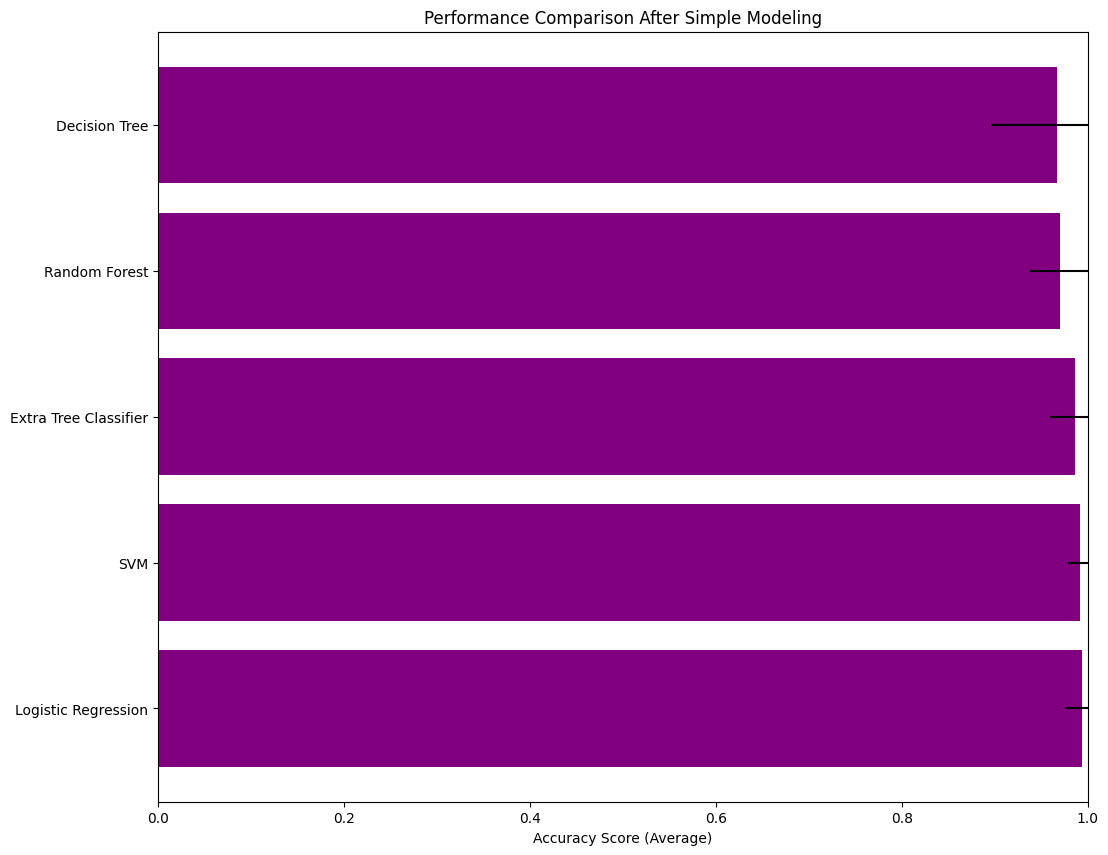

In [9]:
# Model evaluation
estimators = [
    ('Decision Tree', DecisionTreeClassifier),
    ('Logistic Regression', LogisticRegression),
    ('Random Forest', RandomForestClassifier),
    ('SVM', SVC),
    ('Extra Tree Classifier', ExtraTreesClassifier)
]
comparison_cols = ['Algorithm', 'Training Time (Avg)', 'Accuracy (Avg)', 'Accuracy (3xSTD)']
comparison_df = pd.DataFrame(columns=comparison_cols)
cv_split = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
for idx, (name, estimator) in enumerate(estimators):
    cv_results = cross_validate(estimator(), X_train, y_train, cv=cv_split)
    comparison_df.loc[idx, 'Algorithm'] = name
    comparison_df.loc[idx, 'Training Time (Avg)'] = cv_results['fit_time'].mean()
    comparison_df.loc[idx, 'Accuracy (Avg)'] = cv_results['test_score'].mean()
    comparison_df.loc[idx, 'Accuracy (3xSTD)'] = cv_results['test_score'].std() * 3

comparison_df.set_index(keys='Algorithm', inplace=True)
comparison_df.sort_values(by='Accuracy (Avg)', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(comparison_df))
ax.barh(y_pos, comparison_df['Accuracy (Avg)'], xerr=comparison_df['Accuracy (3xSTD)'], color='purple')
ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_df.index)
ax.set_xlabel('Accuracy Score (Average)')
ax.set_title('Performance Comparison After Simple Modeling')
ax.set_xlim(0, 1)
plt.show()

`cross_validate` - evaulvates estimator preformance using cross validation

`StratifiedShuffleSplit` - Type of Stratergy used for cross validation. shuffles the data before splitting, maintains randomness and reproducibility

In [10]:
# Training and evaluating the best model
best_model_name = comparison_df.index[0]

# Map model names to their corresponding class names in scikit-learn
model_name_mapping = {
    'Decision Tree': 'DecisionTreeClassifier',
    'Logistic Regression': 'LogisticRegression',
    'Random Forest': 'RandomForestClassifier',
    'SVM': 'SVC',
    'Extra Tree Classifier': 'ExtraTreesClassifier'
}


In [11]:
# Retrieve the corresponding class name
if best_model_name in model_name_mapping:
    best_model_class = model_name_mapping[best_model_name]
    best_model = globals()[best_model_class]()  # Instantiate the class
    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)
    print('The accuracy of the best model on the test set:', accuracy_score(y_test, predictions))
else:
    print("Error: Model name not found in mapping")


The accuracy of the best model on the test set: 1.0


In [12]:
# Saving the best model
dump((best_model, vect), 'best_model.pkl')


['best_model.pkl']

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       102
           1       1.00      0.94      0.97        98

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        98

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       102
           1       1.00      0.98      0.99        98

    accuracy                           0.99       200

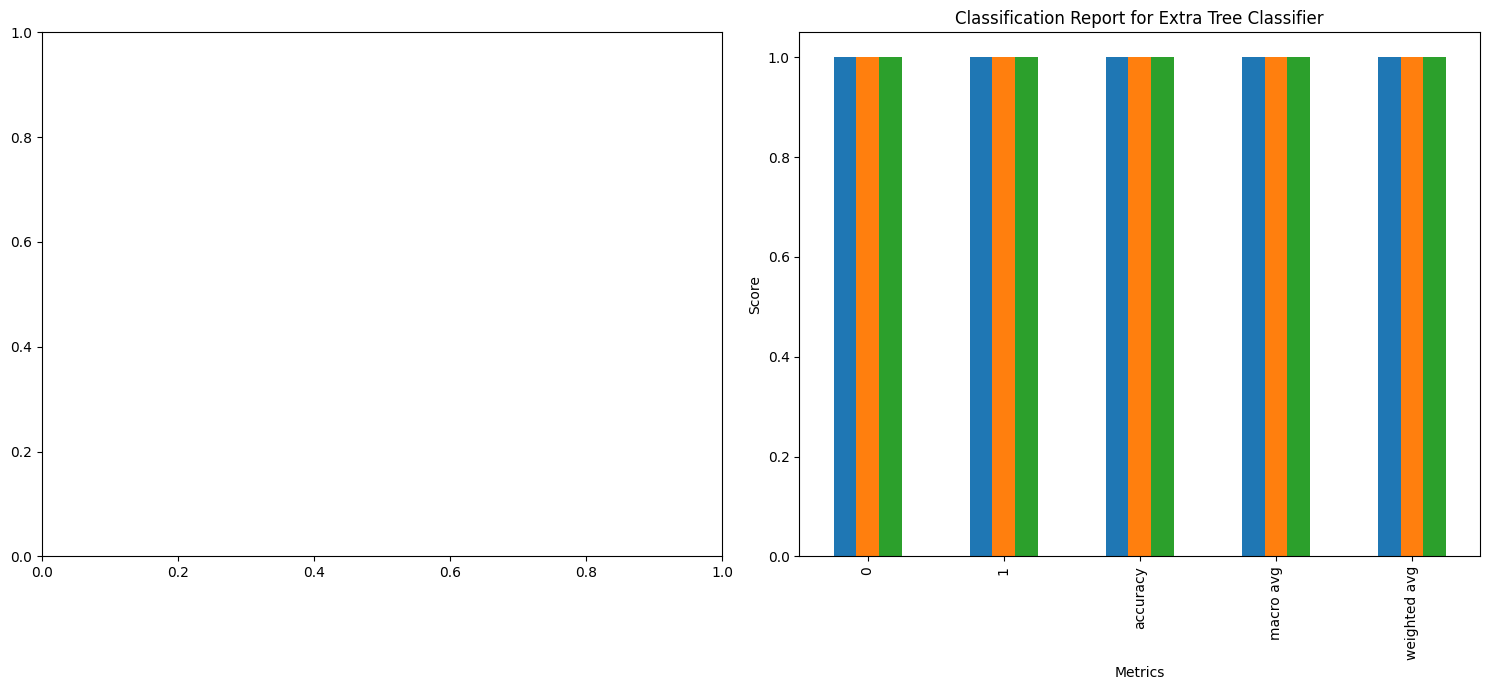

In [13]:
# Generating and displaying classification reports
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
for idx, (name, estimator) in enumerate(estimators):
    clf = estimator()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    df_report = pd.DataFrame(report).transpose()
    df_report.drop(columns=['support'], inplace=True)
    df_report.plot(kind='bar', ax=axes[1], legend=False)
    axes[1].set_title('Classification Report')
    axes[1].set_xlabel('Metrics')
    axes[1].set_ylabel('Score')
    axes[1].set_title(f'Classification Report for {name}')
plt.tight_layout()
plt.show()